# Implementing BTYD in Python *(using lifetimes)*

Hello
This notebook is an introduction to BTYD (Buy Till You Die) model implementation in python using the ["lifetimes" package](https://pypi.python.org/pypi/Lifetimes).

## Introduction

Lifetimes can be used to analyze your users based on a few assumption:

1. Users interact with you when they are "alive".
2. Users under study may "die" after some period of time.

I've quoted "alive" and "die" as these are the most abstract terms: feel free to use your own defintion of "alive" and "die" (they are used similarly to "birth" and "death" in survival analysis). Whenever we have individuals repeating occurrences, we can use Lifetimes to help understand user behaviour.

### Applications

If this is too abstract, consider these applications:

- Predicting how often a visitor will return to your website. (Alive = visiting. Die = decided the website wasn't for them)
- Understanding how frequently a patient may return to a hospital. (Alive = visiting. Die = maybe the patient moved to a new city, or became deceased.)
- Predicting individuals who have churned from an app using only their usage history. (Alive = logins. Die = removed the app)
- Predicting repeat purchases from a customer. (Alive = actively purchasing. Die = became disinterested with your product)
- Predicting the lifetime values of your customers

### Specific Application: Customer Lifetime Value
As emphasized by P. Fader and B. Hardie, understanding and acting on customer lifetime value (CLV) is the most important part of your business's sales efforts. [And (apparently) everyone is doing it wrong](https://www.youtube.com/watch?v=guj2gVEEx4s) *Lifetimes* is a Python library to calculate CLV for you.


## Installation

pip install lifetimes

Requirements are only Numpy, Scipy, Pandas (and optionally-but-seriously matplotlib).

## Quickstart

For the following examples, we'll use a dataset from an ecommerce provider to analyze their customers' repeat purchases. The examples below are using the `cdnow_customers.csv` located in the `datasets/` directory.

In [1]:
from lifetimes.datasets import load_cdnow

In [6]:
data = load_cdnow()

In [9]:
data.head()

,ID,frequency,recency,T
0,1,2,30.43,38.86
1,2,1,1.71,38.86
2,3,0,0.00,38.86
3,4,0,0.00,38.86
4,5,0,0.00,38.86


#### What do these columns represent?

- `frequency` represents the number of *repeat* purchases the customer has made. This means that it's one less than the total number of purchases. 
- `T` represents the age of the customer in whatever time units chosen (weekly above). This is equal to the duration between a customer's first purchase and the end of the period under study.
- `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

If your data is not in the format (very common), there are [utility functions](#example-using-transactional-datasets) in lifetimes to transform your data to look like this.

#### Fitting models to our data

We'll use the **BG/NBD model** first. Interested in the model? See this [nice paper here](http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf)


In [10]:
from lifetimes import BetaGeoFitter

In [11]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print bgf

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


After fitting, we have lots of nice methods and properties attached to the fitter object.

#### How to use the `penalizer_coef`

For small samples sizes, the parameters can get implausibly large, so by adding a positive `penalizer_coef` to the call to `fit`, we can control how large these parameters can be. In typical applications, penalizers on the order of 0.001 to 0.1 are effective. See this [blog article](https://dataorigami.net/blogs/napkin-folding/a-real-life-mistake-i-made-about-penalizer-terms) for more on the history of penalizers in lifetimes. 

#### Visualizing our Frequency/Recency Matrix
Consider: a customer bought from you every day for three weeks straight, and we haven't heard from them in months. What are the chances they are still "alive"? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the **Frequency/Recency matrix**, which computes the expected number of transactions a artifical customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

To plot the **Frequency/Recency matrix** we need to also import the matplotlib.pyplot module.
TO show the plot inline (on the same page) we use the "%matplotlibe inline" command.

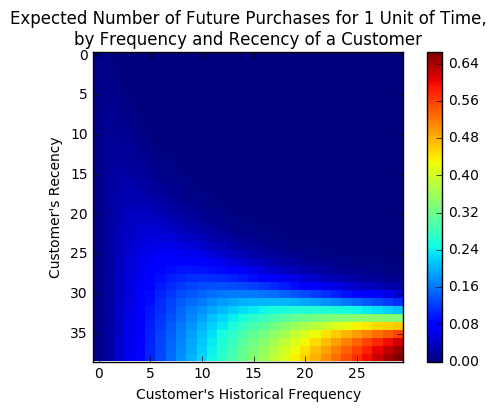

In [14]:
from lifetimes.plotting import plot_frequency_recency_matrix

import matplotlib.pyplot as plt
%matplotlib inline

plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 25 times from you, and their lastest purchase was when they were 35 weeks old (given the individual is 35 weeks old), then they are your best customer (bottom-right). Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven't seen them in weeks.

There's also that beautiful "tail" around (5,25). That represents the customer who buys infrequently, but we've seen him or her recently, so they *might* buy again - we're not sure if they are dead or just between purchases.

Another interesting matrix to look at is the probability of still being *alive*:

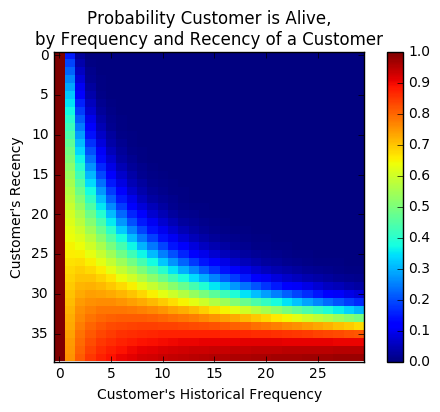

In [15]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

#### Ranking customers from best to worst

Let's return to our customers and rank them from "highest expected purchases in the next period" to lowest. Models expose a method that will predict a customer's expected purchases in the next period using their history.

In [17]:
t = 1

data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, data['frequency'], data['recency'], data['T']
)

In [18]:
data.sort_values(by='predicted_purchases').tail()

,ID,frequency,recency,T,predicted_purchases
508,509,18,35.14,35.86,0.424877
840,841,19,34.00,34.14,0.474738
1980,1981,17,28.43,28.86,0.486526
156,157,29,37.71,38.00,0.662396
1515,1516,26,30.86,31.00,0.710623


Great, we can see that the customer who has made 26 purchases, and bought very recently from us, is probably going to buy again in the next period.

#### Assessing model fit

Ok, we can predict and we can visualize our customers' behaviour, but is our model correct? There are a few ways to assess the model's correctness. The first is to compare your data versus artifical data simulated with your fitted model's parameters.

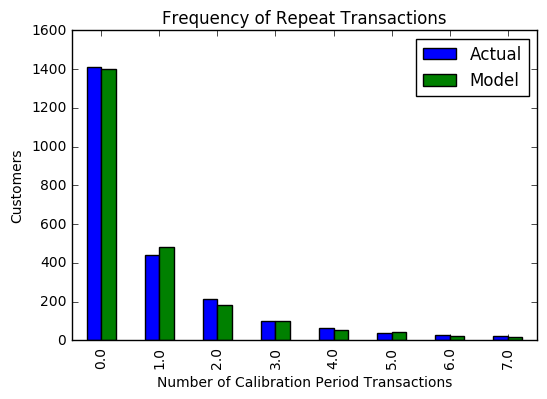

In [19]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

We can see that our actual data and our simulated data line up well. This proves that our model doesn't suck.

#### Example using transactional datasets

Most often, the dataset you have at hand will be at the transaction level. Lifetimes has some utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).


In [21]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()

In [22]:
transaction_data.head()

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2


In [23]:
summary = summary_data_from_transaction_data(
    transaction_data, 'id', 'date', observation_period_end='2014-12-31'
)

summary.head()

,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0


In [24]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

#### More model fitting

With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [26]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
calibration_period_end='2014-09-01',
observation_period_end='2014-12-31' ) 

In [27]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
0,0.0,0.0,177.0,0.0,121
1,0.0,0.0,103.0,0.0,121
2,6.0,142.0,171.0,0.0,121
3,0.0,0.0,26.0,0.0,121
4,2.0,9.0,62.0,0.0,121


With this dataset, we can perform fitting on the `_cal` columns, and test on the `_holdout` columns:

In [28]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

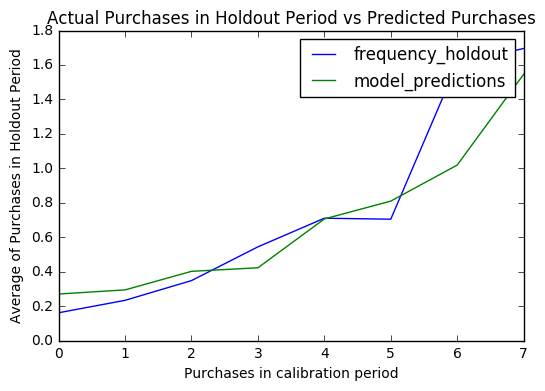

In [29]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

#### Customer Predictions

Based on customer history, we can predict what an individuals future purchases might look like:

In [32]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]

# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.057651146453261651

### Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to
our trained model. For example:

In [33]:
from lifetimes.plotting import plot_history_alive

lifetimes\plotting.py:203: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  customer_history = customer_history.resample(freq, how='sum').reset_index()
lifetimes\utils.py:213: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  purchase_history = customer_history.resample(freq, how='sum').fillna(0)['transactions'].values


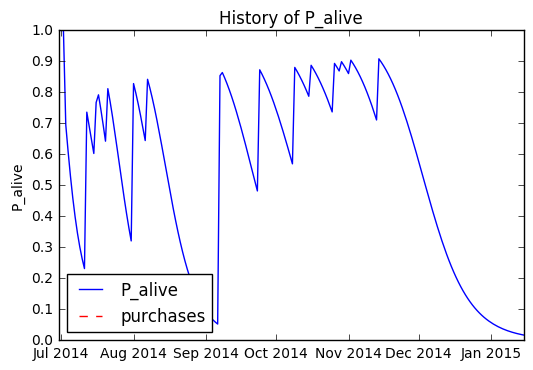

In [34]:
id = 35
days_since_birth = 200
sp_trans = transaction_data.ix[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

### Estimating Customers' Lifetime Value  
For this whole time we didn't take into account the economic value of each transaction and we focused mainly on
transactions' occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data
from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [35]:
from lifetimes.datasets import load_summary_data_with_monetary_value

In [36]:
summary_with_money_value = load_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

In [37]:
returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


#### The Gamma-Gamma model and the independence assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel,
which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no
relationship between the monetary value and the purchase frequency. In practice we need to check whether
the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [39]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [40]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
returning_customers_summary['monetary_value'])
print ggf 

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


We can now estimate the average transaction value:

In [43]:
print ggf.conditional_expected_average_profit(
summary_with_money_value['frequency'],
summary_with_money_value['monetary_value']
).head()

customer_id
1    24.658616
2    18.911479
3    35.171006
4    35.171006
5    35.171006
dtype: float64


In [49]:
print "Expected conditional average profit: %s, Average profit: %s" % (
ggf.conditional_expected_average_profit(
summary_with_money_value['frequency'],
summary_with_money_value['monetary_value']
).mean(),

summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
)

Expected conditional average profit: 35.2529605529, Average profit: 35.078551797


While for computing the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital:

In [51]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print ggf.customer_lifetime_value(
bgf, #the model to use to predict the number of future transactions
summary_with_money_value['frequency'],
summary_with_money_value['recency'],
summary_with_money_value['T'],
summary_with_money_value['monetary_value'],
time=12, # months
discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10)

customer_id
1      140.094573
2       18.943370
3       38.180363
4       38.180363
5       38.180363
6     1003.844333
7       28.109544
8       38.180363
9      167.416308
10      38.180363
Name: clv, dtype: float64


# THE END